In [80]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
import seaborn as sns

sys.path.append('../../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### DS Patient Hours Recomendation Models

#### Plan is to train boosted tree model with both sfere and claims features
- Use last 30d as test set
- also train two versions of quantile model on best features
    1. with current hrs
    2. without current hrs

In [168]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_rec_hrs_modelling_w_claims_20230110.csv', low_memory=False)
print(f'{df.shape[0]} samples')
df.head()

15710 samples


,sfere_id,patient_id,payer_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,group_id_ft,glaucoma_ddos_ft,cataract_ddos_ft,behavioral_health_ddos_ft,osteoporosis_ddos_ft,hiv_ddos_ft,transplants_ddos_ft,obesity_ddos_ft,cancer_ddos_ft,hip_pelvic_fracture_ddos_ft,sclerosis_ddos_ft,rheumatoid_arthritis_ddos_ft,ckd_ddos_ft,hyperlipidemia_ddos_ft,diabetes_ddos_ft,hypothyroidism_ddos_ft,pressure_ulcer_ddos_ft,weight_loss_ddos_ft,heart_ddos_ft,peptic_ulcer_ddos_ft,anemia_ddos_ft,substance_abuse_ddos_ft,liver_ddos_ft,disabled_ddos_ft,fall_ddos_ft,stroke_ddos_ft,paralysis_ddos_ft,hypertension_ddos_ft,peripheral_vascular_ddos_ft,coagulation_ddos_ft,fluid_ddos_ft,benign_prostatic_hyperplasia_ddos_ft,tbi_ddos_ft,neurocognitive_ddos_ft,pulmonary_ddos_ft,glaucoma_tc_ft,cataract_tc_ft,behavioral_health_tc_ft,osteoporosis_tc_ft,hiv_tc_ft,transplants_tc_ft,obesity_tc_ft,cancer_tc_ft,hip_pelvic_fracture_tc_ft,sclerosis_tc_ft,rheumatoid_arthritis_tc_ft,ckd_tc_ft,hyperlipidemia_tc_ft,diabetes_tc_ft,hypothyroidism_tc_ft,pressure_ulcer_tc_ft,weight_loss_tc_ft,heart_tc_ft,peptic_ulcer_tc_ft,anemia_tc_ft,substance_abuse_tc_ft,liver_tc_ft,disabled_tc_ft,fall_tc_ft,stroke_tc_ft,paralysis_tc_ft,hypertension_tc_ft,peripheral_vascular_tc_ft,coagulation_tc_ft,fluid_tc_ft,benign_prostatic_hyperplasia_tc_ft,tbi_tc_ft,neurocognitive_tc_ft,pulmonary_tc_ft,submitted_last_30d
0,14799,14020,8,93,0,0,0,0,2,0,2.0,0,NaN,1,0.0,0.0,0,0,0,1,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,28,273,2,76,2,3,2,2,2,0,2.0,2,NaN,1,NaN,0.0,0,0,1,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,18.0,15.0,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,382.84,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,348.91,0.00,0.00,0.00,0.0,199.89,0.0,64.27,0.0,0.0,0.0,264.16,348.91,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,125.40,False
2,16896,13517,8,88,2,2,2,2,2,0,2.0,2,NaN,1,2.0,2.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,83.06,0.0,0.0,0.00,0.0,0.0,0.0,83.06,0.00,0.00,0.00,0.00,0.00,0.0,270.11,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,False
3,34342,2911,2,78,1,1,1,2,2,1,2.0,1,NaN,0,NaN,NaN,0,0,2,2,1.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,15.0,10.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,6147,1553,2,69,2,2,2,3,2,2,2.0,2,NaN,1,NaN,0.0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,13.0,13.0,-1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,171.0,8.0,29.0,6.0,

In [169]:
# filter out 0 recs
df = df.loc[df.reporting_rec_hrs_tg > 0]
print(f'{df.shape[0]} samples above 0')

14846 samples above 0


In [170]:
df.payer_id_ft.value_counts()

5     2766
2     2725
4     2341
6     2294
8     1595
9     1239
13     938
12     758
1      189
7        1
Name: payer_id_ft, dtype: int64

In [171]:
# let's ignore payer id 7 with 1 sample
# df = df.loc[df.payer_id_ft != 7]

In [172]:
payer_ids = [5, 2, 4, 6, 8, 9, 13, 12, 1]

In [173]:
payer_ids[1:-3]

[2, 4, 6, 8, 9]

### Features

In [174]:
potential_features = [f for f in df.columns if f.endswith('_ft')]
potential_features 

['payer_id_ft',
 'age_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'reporting_current_hrs_ft',
 'group_id_ft',
 'glaucoma_ddos_ft',
 'cataract_ddos_ft',
 'behavioral_health_ddos_ft',
 'osteoporosis_ddos_ft',
 'hiv_ddos_ft',
 'transplant

In [175]:
categorical_features = [
 'payer_id_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'group_id_ft'
]

cont_features = [
 # 'reporting_current_hrs_ft',
 'age_ft',
    
 'glaucoma_ddos_ft',
 'cataract_ddos_ft',
 'behavioral_health_ddos_ft',
 'osteoporosis_ddos_ft',
 'hiv_ddos_ft',
 'transplants_ddos_ft',
 'obesity_ddos_ft',
 'cancer_ddos_ft',
 'hip_pelvic_fracture_ddos_ft',
 'sclerosis_ddos_ft',
 'rheumatoid_arthritis_ddos_ft',
 'ckd_ddos_ft',
 'hyperlipidemia_ddos_ft',
 'diabetes_ddos_ft',
 'hypothyroidism_ddos_ft',
 'pressure_ulcer_ddos_ft',
 'weight_loss_ddos_ft',
 'heart_ddos_ft',
 'peptic_ulcer_ddos_ft',
 'anemia_ddos_ft',
 'substance_abuse_ddos_ft',
 'liver_ddos_ft',
 'disabled_ddos_ft',
 'fall_ddos_ft',
 'stroke_ddos_ft',
 'paralysis_ddos_ft',
 'hypertension_ddos_ft',
 'peripheral_vascular_ddos_ft',
 'coagulation_ddos_ft',
 'fluid_ddos_ft',
 'benign_prostatic_hyperplasia_ddos_ft',
 'tbi_ddos_ft',
 'neurocognitive_ddos_ft',
 'pulmonary_ddos_ft',
    
 #     'glaucoma_tc_ft',
 # 'cataract_tc_ft',
 # 'behavioral_health_tc_ft',
 # 'osteoporosis_tc_ft',
 # 'hiv_tc_ft',
 # 'transplants_tc_ft',
 # 'obesity_tc_ft',
 # 'cancer_tc_ft',
 # 'hip_pelvic_fracture_tc_ft',
 # 'sclerosis_tc_ft',
 # 'rheumatoid_arthritis_tc_ft',
 # 'ckd_tc_ft',
 # 'hyperlipidemia_tc_ft',
 # 'diabetes_tc_ft',
 # 'hypothyroidism_tc_ft',
 # 'pressure_ulcer_tc_ft',
 # 'weight_loss_tc_ft',
 # 'heart_tc_ft',
 # 'peptic_ulcer_tc_ft',
 # 'anemia_tc_ft',
 # 'substance_abuse_tc_ft',
 # 'liver_tc_ft',
 # 'disabled_tc_ft',
 # 'fall_tc_ft',
 # 'stroke_tc_ft',
 # 'paralysis_tc_ft',
 # 'hypertension_tc_ft',
 # 'peripheral_vascular_tc_ft',
 # 'coagulation_tc_ft',
 # 'fluid_tc_ft',
 # 'benign_prostatic_hyperplasia_tc_ft',
 # 'tbi_tc_ft',
 # 'neurocognitive_tc_ft',
 # 'pulmonary_tc_ft'
]
 

features = categorical_features + cont_features
target = 'reporting_rec_hrs_tg'
categorical_feature_indexes = [i for i in range(len(categorical_features))]

In [176]:
# skip payer_id 5 because no recent sferes

payers:  [2, 4, 6, 8, 9, 13, 12, 1]
Payer ID:  2
n samples for 2 2725
417 test samples, for 235 unique patients
2308 training samples, for 1650 unique patients
477 val samples, for 346 unique patients
1831 train samples, for 1304 unique patients


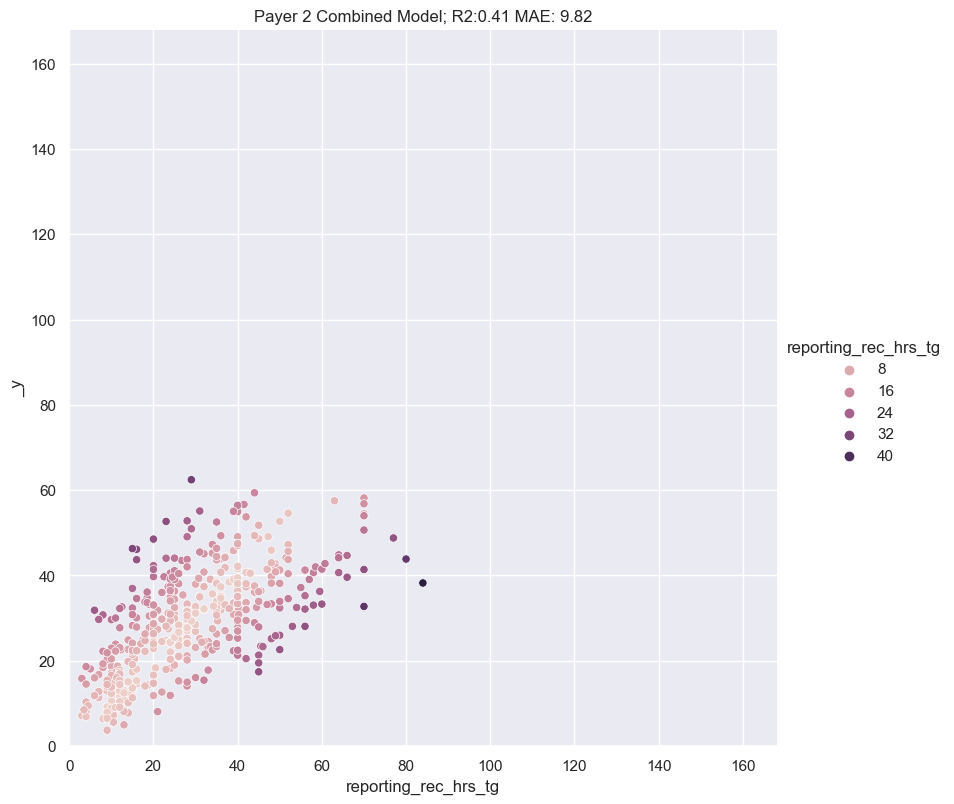

Payer 2 All assessor model features training
group_id_ft 0.182  +/- 0.006
age_ft   0.159  +/- 0.004
toileting_ft 0.081  +/- 0.002
meal_prep_ft 0.073  +/- 0.003
dressing_ft 0.050  +/- 0.002
medication_management_ft 0.045  +/- 0.002
transfer_bed_to_chair_ft 0.039  +/- 0.002
diabetes_ddos_ft 0.038  +/- 0.001
paralysis_ddos_ft 0.036  +/- 0.002
shopping_ft 0.033  +/- 0.001
hypertension_ddos_ft 0.033  +/- 0.001
grooming_ft 0.033  +/- 0.001
transfer_chair_to_standing_ft 0.029  +/- 0.001
eating_ft 0.026  +/- 0.001
has_dementia_ft 0.023  +/- 0.001
hyperlipidemia_ddos_ft 0.023  +/- 0.001
incontinence_frequency_ft 0.022  +/- 0.001
mobility_ft 0.019  +/- 0.001
fluid_ddos_ft 0.018  +/- 0.001
calling_friends_and_family_ft 0.018  +/- 0.001
heart_ddos_ft 0.017  +/- 0.001
neurocognitive_ddos_ft 0.016  +/- 0.001
pulmonary_ddos_ft 0.015  +/- 0.001
bathing_ft 0.015  +/- 0.001
behavioral_health_ddos_ft 0.014  +/- 0.001
rheumatoid_arthritis_ddos_ft 0.014  +/- 0.001
ckd_ddos_ft 0.014  +/- 0.001
stroke_ddos_f

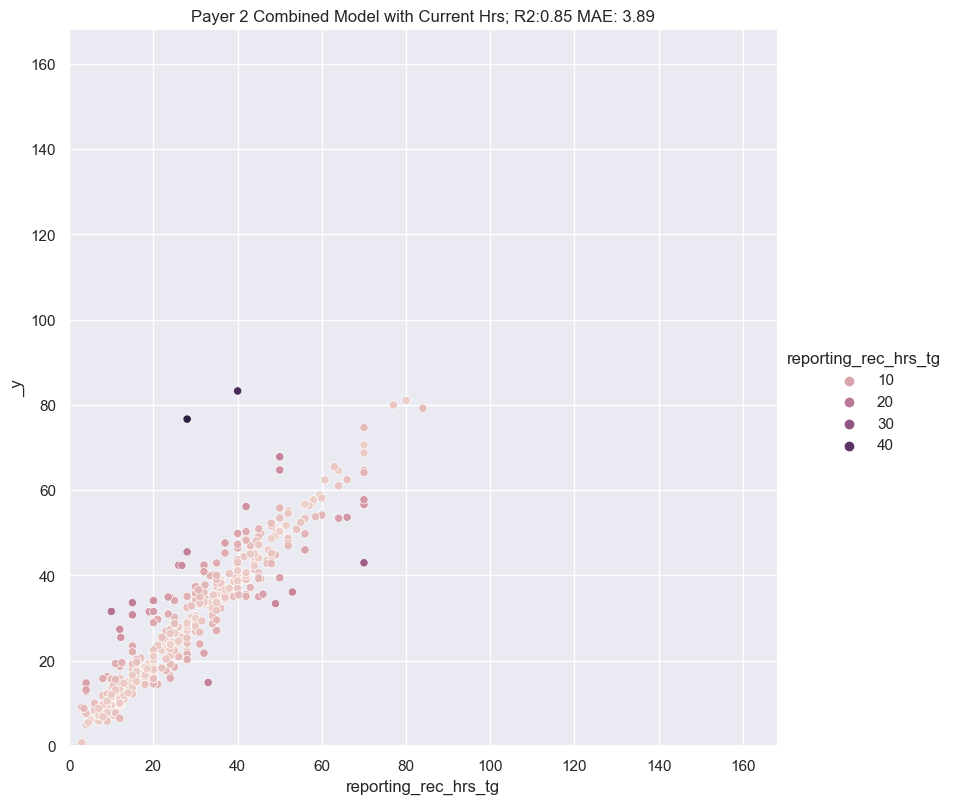

Payer 2 All assessor model features with current hrs
reporting_current_hrs_ft 1.508  +/- 0.041
age_ft   0.016  +/- 0.001
grooming_ft 0.012  +/- 0.000
toileting_ft 0.007  +/- 0.000
heart_ddos_ft 0.005  +/- 0.000
meal_prep_ft 0.005  +/- 0.000
shopping_ft 0.005  +/- 0.000
hypertension_ddos_ft 0.005  +/- 0.000
medication_management_ft 0.005  +/- 0.000
dressing_ft 0.004  +/- 0.000
paralysis_ddos_ft 0.004  +/- 0.000
mobility_ft 0.004  +/- 0.000
eating_ft 0.004  +/- 0.000
hyperlipidemia_ddos_ft 0.004  +/- 0.000
diabetes_ddos_ft 0.003  +/- 0.000
incontinence_frequency_ft 0.003  +/- 0.000
rheumatoid_arthritis_ddos_ft 0.002  +/- 0.000
bathing_ft 0.002  +/- 0.000
pulmonary_ddos_ft 0.002  +/- 0.000
transfer_chair_to_standing_ft 0.002  +/- 0.000
stroke_ddos_ft 0.002  +/- 0.000
transfer_bed_to_chair_ft 0.002  +/- 0.000
behavioral_health_ddos_ft 0.002  +/- 0.000
fluid_ddos_ft 0.002  +/- 0.000
anemia_ddos_ft 0.002  +/- 0.000
obesity_ddos_ft 0.002  +/- 0.000
ckd_ddos_ft 0.002  +/- 0.000
alert_oriented_

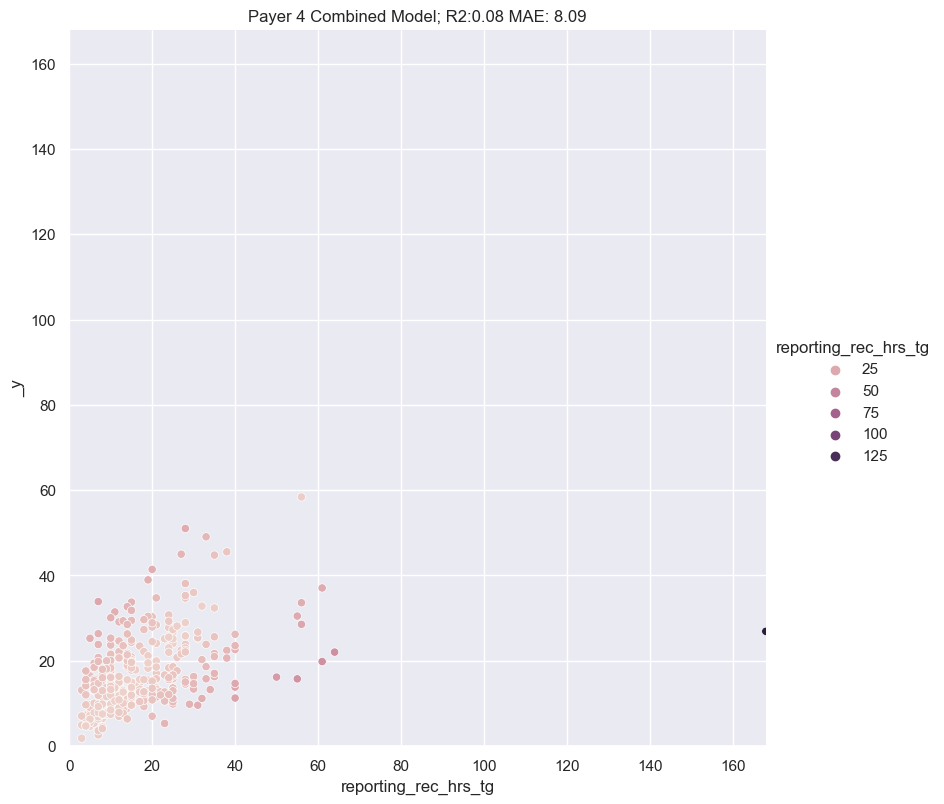

Payer 4 All assessor model features training
age_ft   0.473  +/- 0.039
transfer_bed_to_chair_ft 0.160  +/- 0.007
neurocognitive_ddos_ft 0.079  +/- 0.003
meal_prep_ft 0.072  +/- 0.003
eating_ft 0.064  +/- 0.003
paralysis_ddos_ft 0.052  +/- 0.003
medication_management_ft 0.048  +/- 0.003
mobility_ft 0.044  +/- 0.003
toileting_ft 0.044  +/- 0.002
dressing_ft 0.043  +/- 0.001
shopping_ft 0.039  +/- 0.002
pressure_ulcer_ddos_ft 0.033  +/- 0.003
incontinence_frequency_ft 0.033  +/- 0.001
bathing_ft 0.033  +/- 0.001
alert_oriented_self_ft 0.029  +/- 0.002
hypertension_ddos_ft 0.026  +/- 0.001
transfer_chair_to_standing_ft 0.026  +/- 0.001
grooming_ft 0.022  +/- 0.001
alert_oriented_day_time_ft 0.020  +/- 0.001
alert_oriented_place_ft 0.015  +/- 0.001
calling_friends_and_family_ft 0.015  +/- 0.001
articulating_needs_ft 0.014  +/- 0.001
diabetes_ddos_ft 0.013  +/- 0.001
has_dementia_ft 0.013  +/- 0.001
hyperlipidemia_ddos_ft 0.012  +/- 0.001
behavioral_health_ddos_ft 0.012  +/- 0.001
pulmonary_

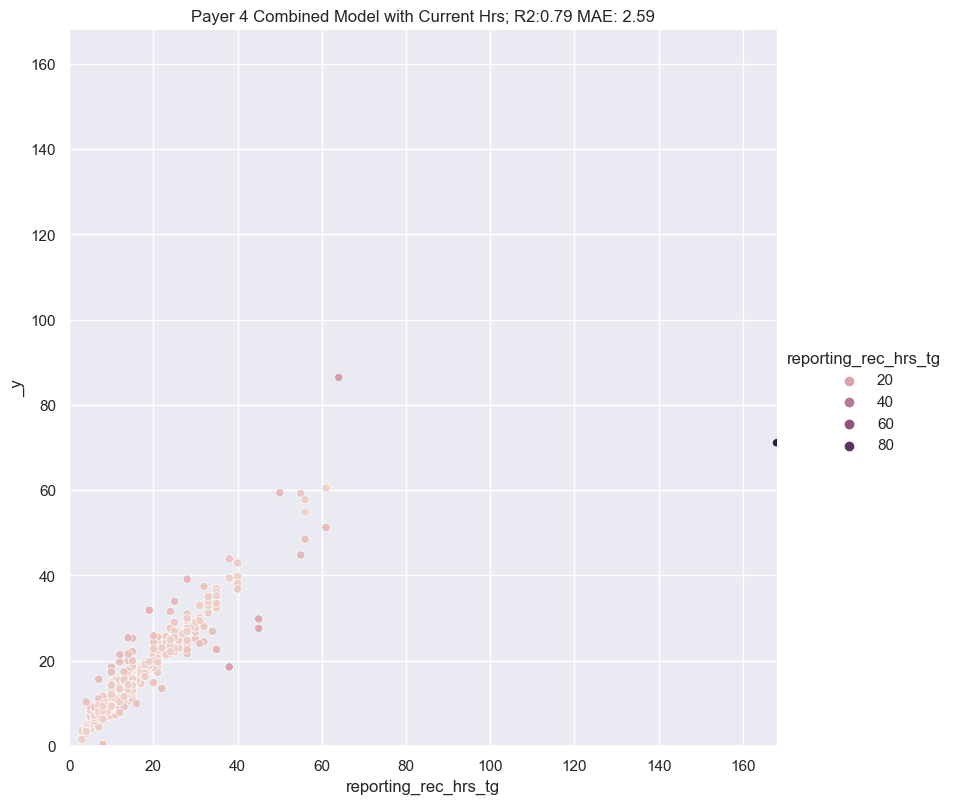

Payer 4 All assessor model features with current hrs
reporting_current_hrs_ft 1.393  +/- 0.035
age_ft   0.056  +/- 0.006
shopping_ft 0.014  +/- 0.002
transfer_bed_to_chair_ft 0.011  +/- 0.001
bathing_ft 0.009  +/- 0.001
dressing_ft 0.009  +/- 0.000
eating_ft 0.008  +/- 0.001
toileting_ft 0.006  +/- 0.000
meal_prep_ft 0.006  +/- 0.000
medication_management_ft 0.005  +/- 0.000
neurocognitive_ddos_ft 0.004  +/- 0.000
mobility_ft 0.004  +/- 0.000
grooming_ft 0.004  +/- 0.000
incontinence_frequency_ft 0.003  +/- 0.000
transfer_chair_to_standing_ft 0.002  +/- 0.000
alert_oriented_day_time_ft 0.002  +/- 0.000
pressure_ulcer_ddos_ft 0.001  +/- 0.000
hyperlipidemia_ddos_ft 0.001  +/- 0.000
hypertension_ddos_ft 0.001  +/- 0.000
heart_ddos_ft 0.001  +/- 0.000
paralysis_ddos_ft 0.001  +/- 0.000
stroke_ddos_ft 0.001  +/- 0.000
hypothyroidism_ddos_ft 0.001  +/- 0.000
has_dementia_ft 0.001  +/- 0.000
articulating_needs_ft 0.001  +/- 0.000
ckd_ddos_ft 0.001  +/- 0.000
pulmonary_ddos_ft 0.001  +/- 0.00

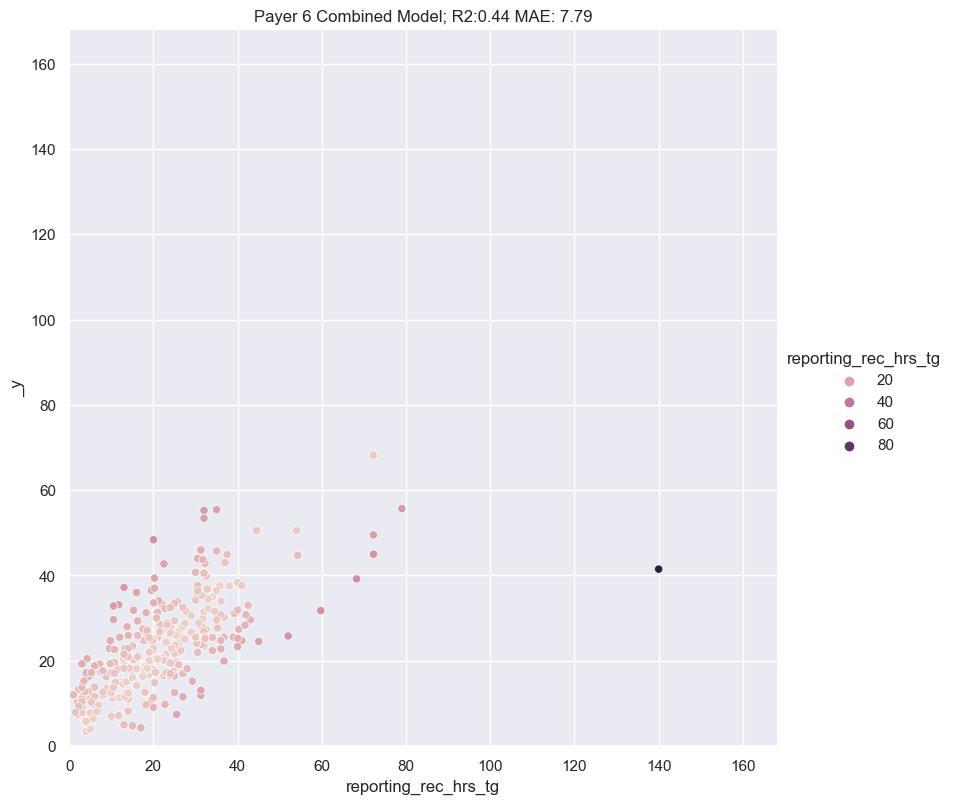

Payer 6 All assessor model features training
toileting_ft 0.196  +/- 0.006
age_ft   0.152  +/- 0.006
medication_management_ft 0.066  +/- 0.002
meal_prep_ft 0.059  +/- 0.003
dressing_ft 0.043  +/- 0.001
eating_ft 0.041  +/- 0.002
bathing_ft 0.034  +/- 0.001
alert_oriented_day_time_ft 0.032  +/- 0.002
transfer_chair_to_standing_ft 0.031  +/- 0.001
hypertension_ddos_ft 0.030  +/- 0.001
behavioral_health_ddos_ft 0.028  +/- 0.001
shopping_ft 0.023  +/- 0.001
transfer_bed_to_chair_ft 0.022  +/- 0.001
paralysis_ddos_ft 0.021  +/- 0.001
grooming_ft 0.021  +/- 0.001
diabetes_ddos_ft 0.020  +/- 0.001
rheumatoid_arthritis_ddos_ft 0.019  +/- 0.001
pulmonary_ddos_ft 0.018  +/- 0.001
mobility_ft 0.018  +/- 0.001
weight_loss_ddos_ft 0.016  +/- 0.001
hyperlipidemia_ddos_ft 0.014  +/- 0.001
group_id_ft 0.012  +/- 0.000
obesity_ddos_ft 0.012  +/- 0.001
heart_ddos_ft 0.011  +/- 0.001
neurocognitive_ddos_ft 0.011  +/- 0.001
incontinence_frequency_ft 0.011  +/- 0.001
ckd_ddos_ft 0.011  +/- 0.000
calling_fr

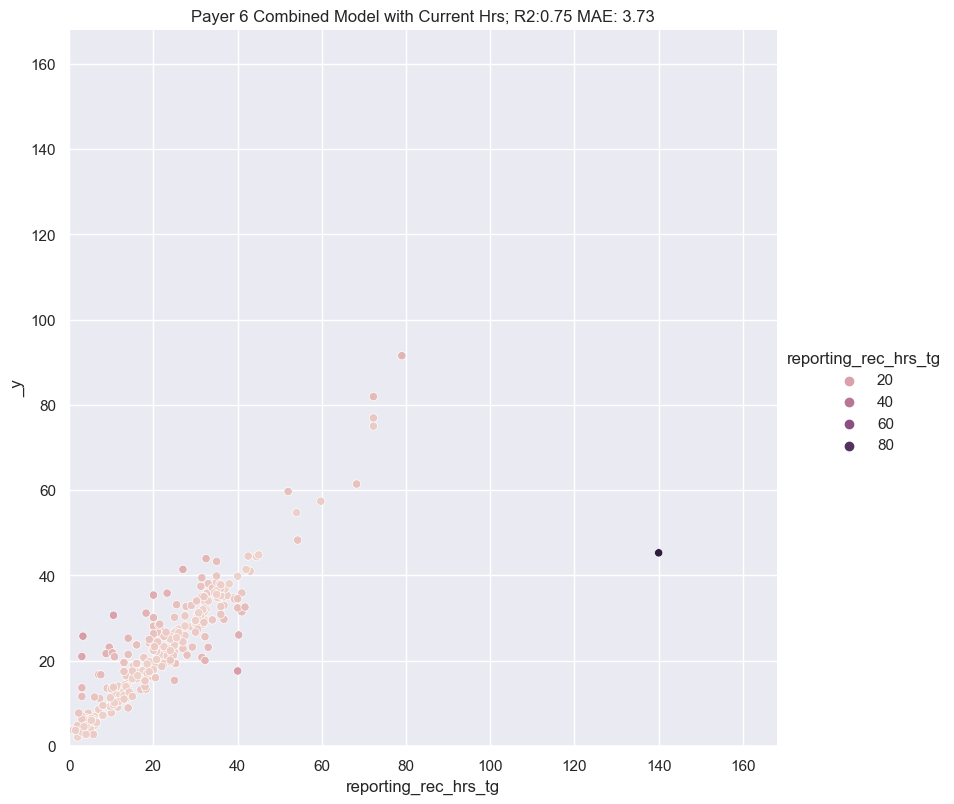

Payer 6 All assessor model features with current hrs
reporting_current_hrs_ft 1.297  +/- 0.033
dressing_ft 0.020  +/- 0.001
toileting_ft 0.015  +/- 0.001
age_ft   0.014  +/- 0.001
medication_management_ft 0.010  +/- 0.001
grooming_ft 0.010  +/- 0.001
bathing_ft 0.008  +/- 0.000
meal_prep_ft 0.007  +/- 0.000
alert_oriented_day_time_ft 0.006  +/- 0.001
hypertension_ddos_ft 0.005  +/- 0.000
pressure_ulcer_ddos_ft 0.005  +/- 0.000
transfer_chair_to_standing_ft 0.004  +/- 0.000
behavioral_health_ddos_ft 0.004  +/- 0.000
diabetes_ddos_ft 0.004  +/- 0.000
paralysis_ddos_ft 0.004  +/- 0.000
transfer_bed_to_chair_ft 0.004  +/- 0.000
heart_ddos_ft 0.003  +/- 0.000
weight_loss_ddos_ft 0.003  +/- 0.000
obesity_ddos_ft 0.003  +/- 0.000
hyperlipidemia_ddos_ft 0.003  +/- 0.000
rheumatoid_arthritis_ddos_ft 0.003  +/- 0.000
pulmonary_ddos_ft 0.002  +/- 0.000
anemia_ddos_ft 0.002  +/- 0.000
ckd_ddos_ft 0.002  +/- 0.000
incontinence_frequency_ft 0.002  +/- 0.000
shopping_ft 0.002  +/- 0.000
mobility_ft 0

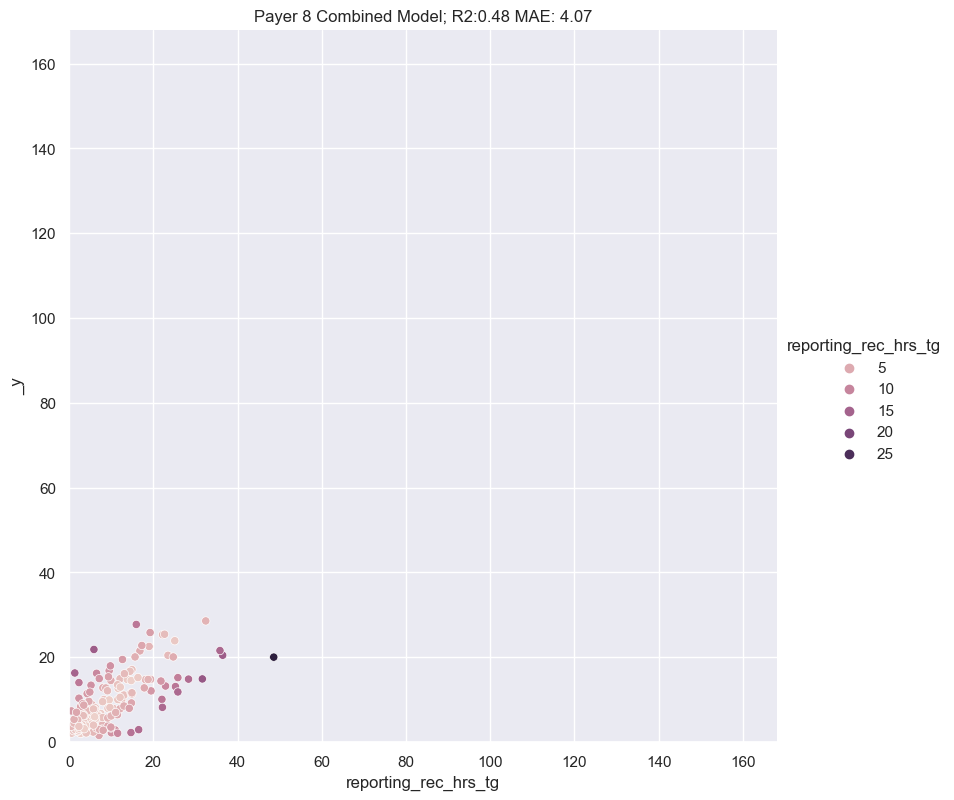

Payer 8 All assessor model features training
age_ft   0.201  +/- 0.007
toileting_ft 0.122  +/- 0.005
meal_prep_ft 0.114  +/- 0.004
dressing_ft 0.113  +/- 0.004
grooming_ft 0.067  +/- 0.003
group_id_ft 0.056  +/- 0.003
medication_management_ft 0.047  +/- 0.002
alert_oriented_day_time_ft 0.044  +/- 0.003
transfer_bed_to_chair_ft 0.043  +/- 0.002
mobility_ft 0.036  +/- 0.002
shopping_ft 0.033  +/- 0.002
diabetes_ddos_ft 0.027  +/- 0.001
hypertension_ddos_ft 0.027  +/- 0.001
calling_friends_and_family_ft 0.025  +/- 0.002
paralysis_ddos_ft 0.022  +/- 0.001
heart_ddos_ft 0.021  +/- 0.001
hyperlipidemia_ddos_ft 0.020  +/- 0.001
transfer_chair_to_standing_ft 0.020  +/- 0.001
eating_ft 0.019  +/- 0.001
incontinence_frequency_ft 0.015  +/- 0.001
bathing_ft 0.014  +/- 0.001
pulmonary_ddos_ft 0.010  +/- 0.001
behavioral_health_ddos_ft 0.010  +/- 0.001
rheumatoid_arthritis_ddos_ft 0.009  +/- 0.000
articulating_needs_ft 0.009  +/- 0.001
ckd_ddos_ft 0.008  +/- 0.000
obesity_ddos_ft 0.007  +/- 0.000
f

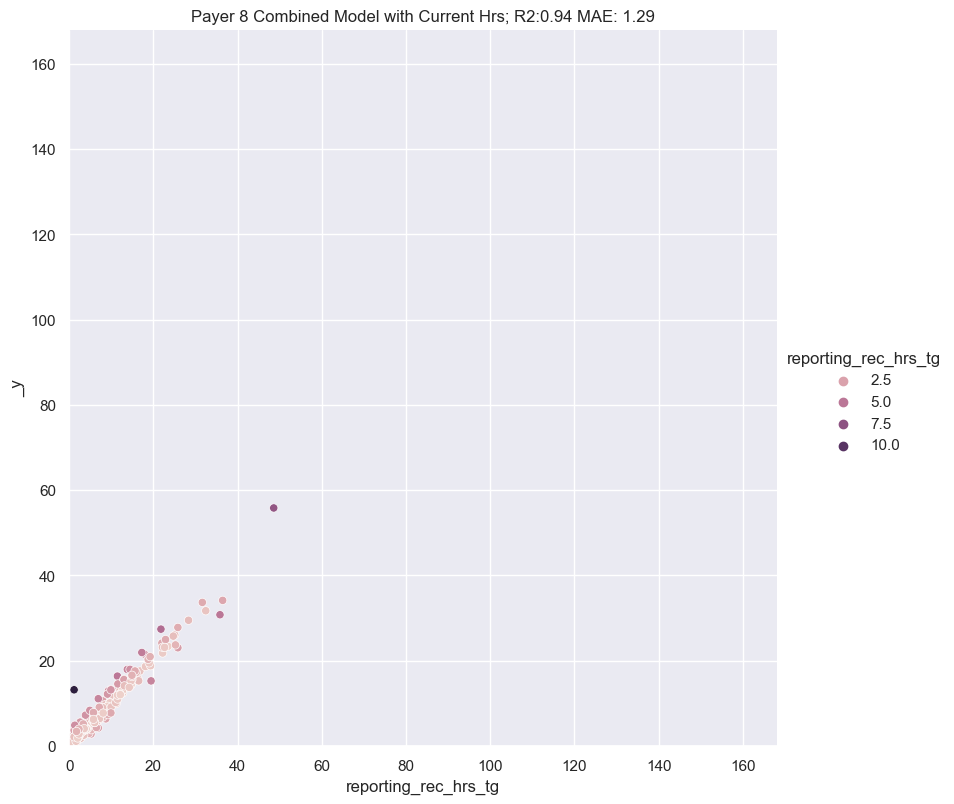

Payer 8 All assessor model features with current hrs
reporting_current_hrs_ft 1.617  +/- 0.048
age_ft   0.014  +/- 0.001
group_id_ft 0.010  +/- 0.002
meal_prep_ft 0.006  +/- 0.001
mobility_ft 0.006  +/- 0.000
bathing_ft 0.006  +/- 0.000
grooming_ft 0.005  +/- 0.000
dressing_ft 0.005  +/- 0.001
transfer_chair_to_standing_ft 0.005  +/- 0.000
hypertension_ddos_ft 0.005  +/- 0.000
eating_ft 0.004  +/- 0.000
toileting_ft 0.004  +/- 0.000
diabetes_ddos_ft 0.003  +/- 0.000
shopping_ft 0.002  +/- 0.000
heart_ddos_ft 0.002  +/- 0.000
incontinence_frequency_ft 0.002  +/- 0.000
hyperlipidemia_ddos_ft 0.002  +/- 0.000
calling_friends_and_family_ft 0.002  +/- 0.000
medication_management_ft 0.002  +/- 0.000
rheumatoid_arthritis_ddos_ft 0.002  +/- 0.000
obesity_ddos_ft 0.002  +/- 0.000
behavioral_health_ddos_ft 0.002  +/- 0.000
paralysis_ddos_ft 0.002  +/- 0.000
has_incontinence_ft 0.001  +/- 0.000
transfer_bed_to_chair_ft 0.001  +/- 0.000
stroke_ddos_ft 0.001  +/- 0.000
anemia_ddos_ft 0.001  +/- 0.0

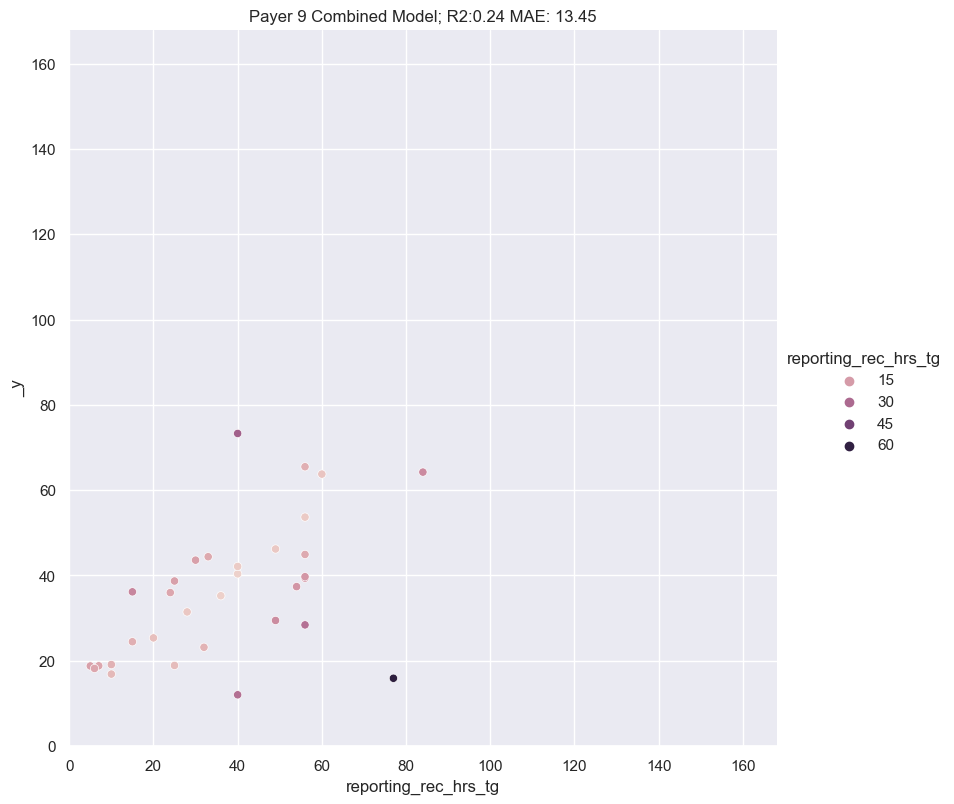

Payer 9 All assessor model features training
transfer_chair_to_standing_ft 0.096  +/- 0.006
age_ft   0.084  +/- 0.003
grooming_ft 0.074  +/- 0.003
paralysis_ddos_ft 0.071  +/- 0.005
dressing_ft 0.059  +/- 0.002
eating_ft 0.058  +/- 0.004
hypertension_ddos_ft 0.053  +/- 0.003
medication_management_ft 0.044  +/- 0.002
has_dementia_ft 0.043  +/- 0.003
diabetes_ddos_ft 0.038  +/- 0.002
toileting_ft 0.037  +/- 0.002
bathing_ft 0.035  +/- 0.001
mobility_ft 0.033  +/- 0.002
meal_prep_ft 0.028  +/- 0.002
rheumatoid_arthritis_ddos_ft 0.027  +/- 0.001
ckd_ddos_ft 0.025  +/- 0.001
hyperlipidemia_ddos_ft 0.022  +/- 0.001
heart_ddos_ft 0.021  +/- 0.001
shopping_ft 0.018  +/- 0.001
stroke_ddos_ft 0.015  +/- 0.001
peripheral_vascular_ddos_ft 0.015  +/- 0.001
pulmonary_ddos_ft 0.014  +/- 0.001
cataract_ddos_ft 0.012  +/- 0.001
anemia_ddos_ft 0.012  +/- 0.001
neurocognitive_ddos_ft 0.012  +/- 0.001
incontinence_frequency_ft 0.011  +/- 0.001
glaucoma_ddos_ft 0.009  +/- 0.001
alert_oriented_day_time_ft 0

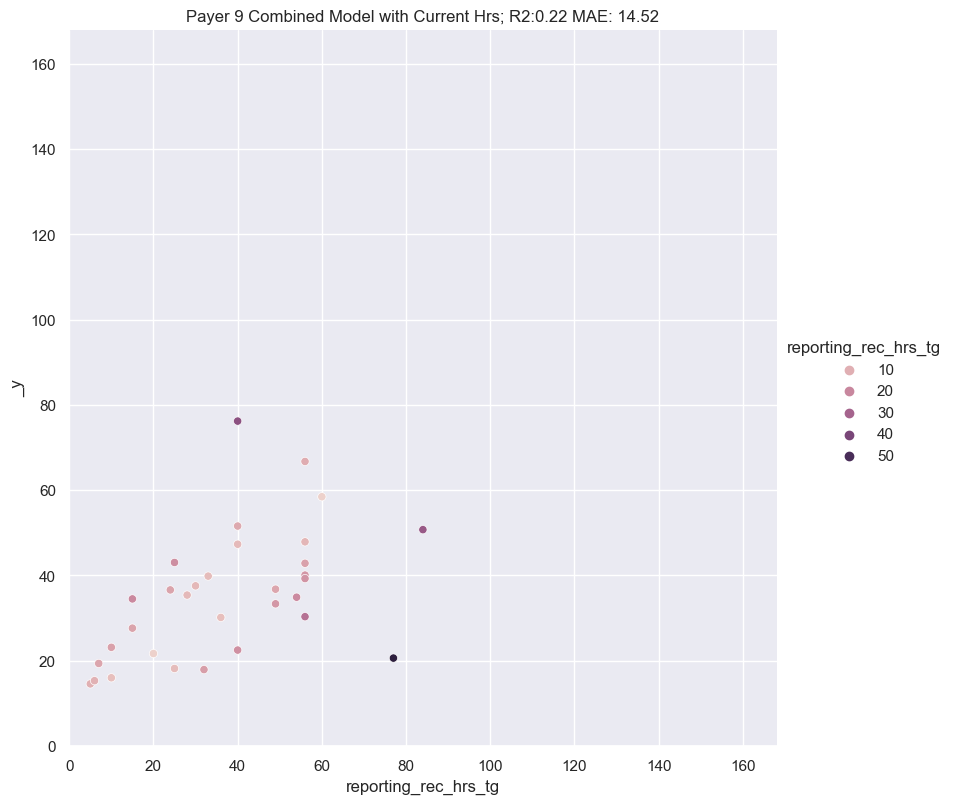

Payer 9 All assessor model features with current hrs
reporting_current_hrs_ft 0.347  +/- 0.020
age_ft   0.068  +/- 0.004
grooming_ft 0.045  +/- 0.002
mobility_ft 0.043  +/- 0.002
dressing_ft 0.042  +/- 0.002
hypertension_ddos_ft 0.035  +/- 0.002
eating_ft 0.032  +/- 0.002
toileting_ft 0.028  +/- 0.002
bathing_ft 0.028  +/- 0.001
transfer_chair_to_standing_ft 0.028  +/- 0.002
medication_management_ft 0.027  +/- 0.001
diabetes_ddos_ft 0.027  +/- 0.001
paralysis_ddos_ft 0.026  +/- 0.001
rheumatoid_arthritis_ddos_ft 0.022  +/- 0.001
has_dementia_ft 0.018  +/- 0.001
hyperlipidemia_ddos_ft 0.018  +/- 0.001
meal_prep_ft 0.017  +/- 0.001
alert_oriented_day_time_ft 0.013  +/- 0.001
ckd_ddos_ft 0.012  +/- 0.001
peripheral_vascular_ddos_ft 0.012  +/- 0.001
incontinence_frequency_ft 0.010  +/- 0.001
shopping_ft 0.010  +/- 0.000
anemia_ddos_ft 0.010  +/- 0.001
cataract_ddos_ft 0.010  +/- 0.001
heart_ddos_ft 0.009  +/- 0.000
pulmonary_ddos_ft 0.008  +/- 0.001
behavioral_health_ddos_ft 0.008  +/- 0.0

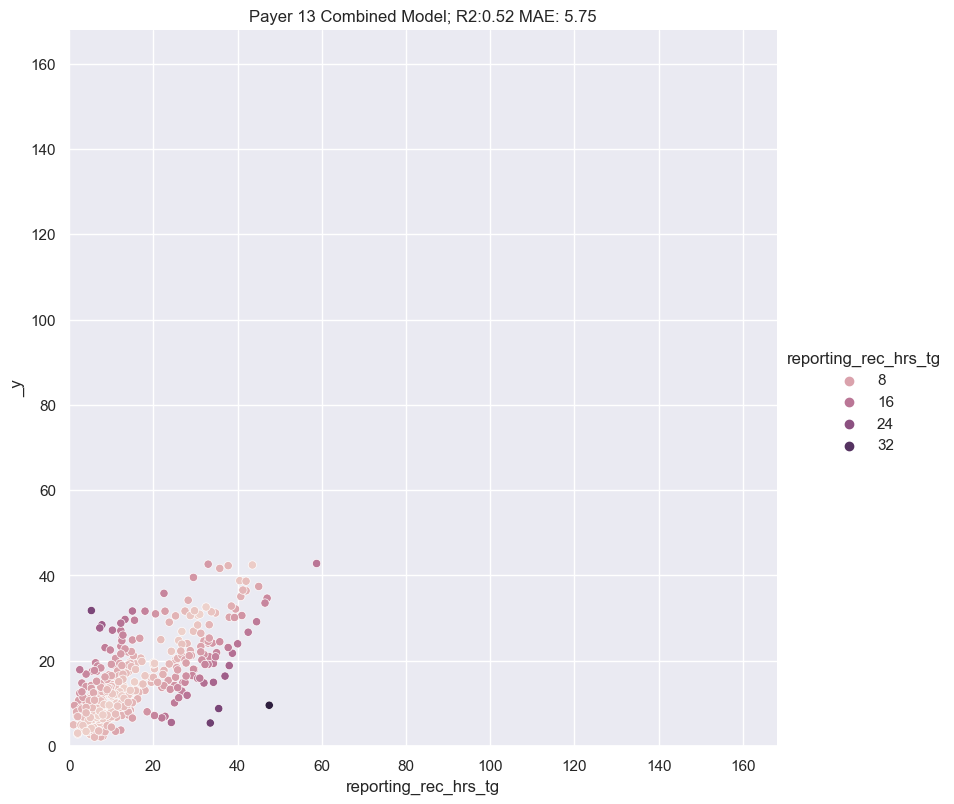

Payer 13 All assessor model features training
toileting_ft 0.131  +/- 0.006
transfer_bed_to_chair_ft 0.119  +/- 0.007
shopping_ft 0.062  +/- 0.004
hypertension_ddos_ft 0.050  +/- 0.004
age_ft   0.049  +/- 0.004
bathing_ft 0.046  +/- 0.003
medication_management_ft 0.046  +/- 0.003
grooming_ft 0.045  +/- 0.004
rheumatoid_arthritis_ddos_ft 0.027  +/- 0.002
alert_oriented_day_time_ft 0.024  +/- 0.001
meal_prep_ft 0.023  +/- 0.002
eating_ft 0.022  +/- 0.002
hyperlipidemia_ddos_ft 0.022  +/- 0.002
pulmonary_ddos_ft 0.020  +/- 0.002
diabetes_ddos_ft 0.019  +/- 0.001
dressing_ft 0.019  +/- 0.001
mobility_ft 0.018  +/- 0.002
hypothyroidism_ddos_ft 0.018  +/- 0.002
incontinence_frequency_ft 0.016  +/- 0.001
ckd_ddos_ft 0.011  +/- 0.001
heart_ddos_ft 0.009  +/- 0.001
transfer_chair_to_standing_ft 0.008  +/- 0.001
stroke_ddos_ft 0.008  +/- 0.001
obesity_ddos_ft 0.007  +/- 0.001
cancer_ddos_ft 0.006  +/- 0.001
glaucoma_ddos_ft 0.006  +/- 0.000
cataract_ddos_ft 0.005  +/- 0.000
peripheral_vascular_d

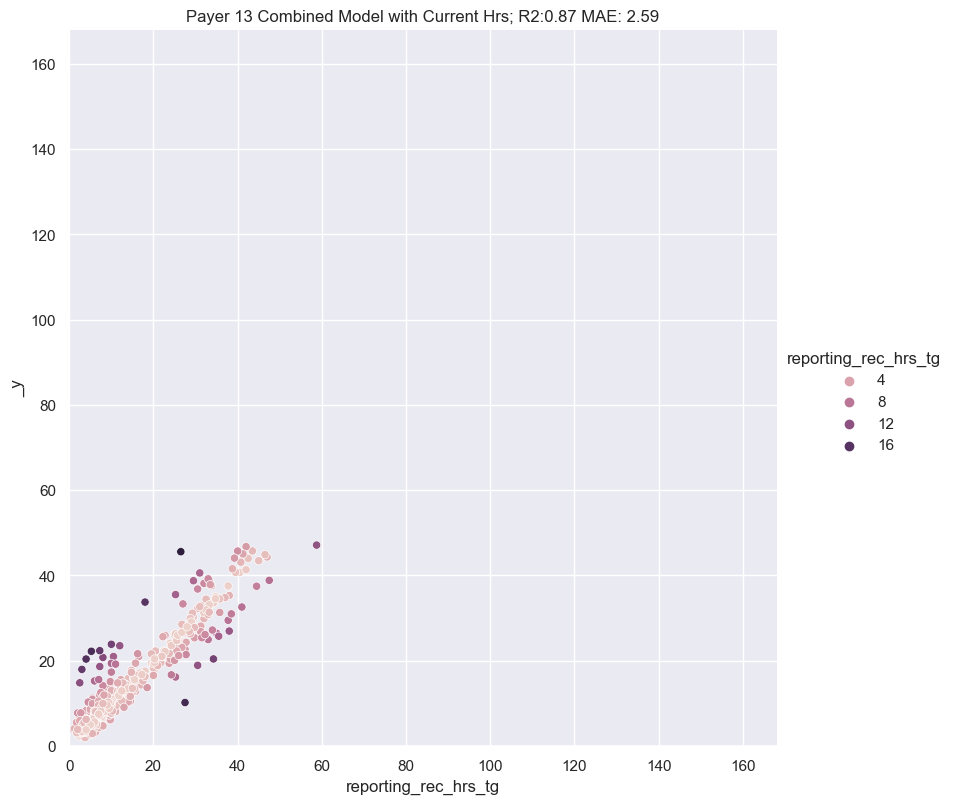

Payer 13 All assessor model features with current hrs
reporting_current_hrs_ft 1.284  +/- 0.068
transfer_bed_to_chair_ft 0.020  +/- 0.002
bathing_ft 0.012  +/- 0.001
osteoporosis_ddos_ft 0.012  +/- 0.002
age_ft   0.009  +/- 0.001
shopping_ft 0.008  +/- 0.001
toileting_ft 0.008  +/- 0.001
hypertension_ddos_ft 0.008  +/- 0.001
behavioral_health_ddos_ft 0.007  +/- 0.001
grooming_ft 0.005  +/- 0.000
eating_ft 0.005  +/- 0.000
meal_prep_ft 0.005  +/- 0.000
rheumatoid_arthritis_ddos_ft 0.005  +/- 0.001
dressing_ft 0.004  +/- 0.000
hyperlipidemia_ddos_ft 0.003  +/- 0.000
has_dementia_ft 0.003  +/- 0.000
incontinence_frequency_ft 0.003  +/- 0.000
ckd_ddos_ft 0.003  +/- 0.000
medication_management_ft 0.003  +/- 0.000
diabetes_ddos_ft 0.002  +/- 0.000
hypothyroidism_ddos_ft 0.002  +/- 0.000
glaucoma_ddos_ft 0.001  +/- 0.000
alert_oriented_day_time_ft 0.001  +/- 0.000
fall_ddos_ft 0.001  +/- 0.000
heart_ddos_ft 0.001  +/- 0.000
neurocognitive_ddos_ft 0.001  +/- 0.000
peripheral_vascular_ddos_ft 0

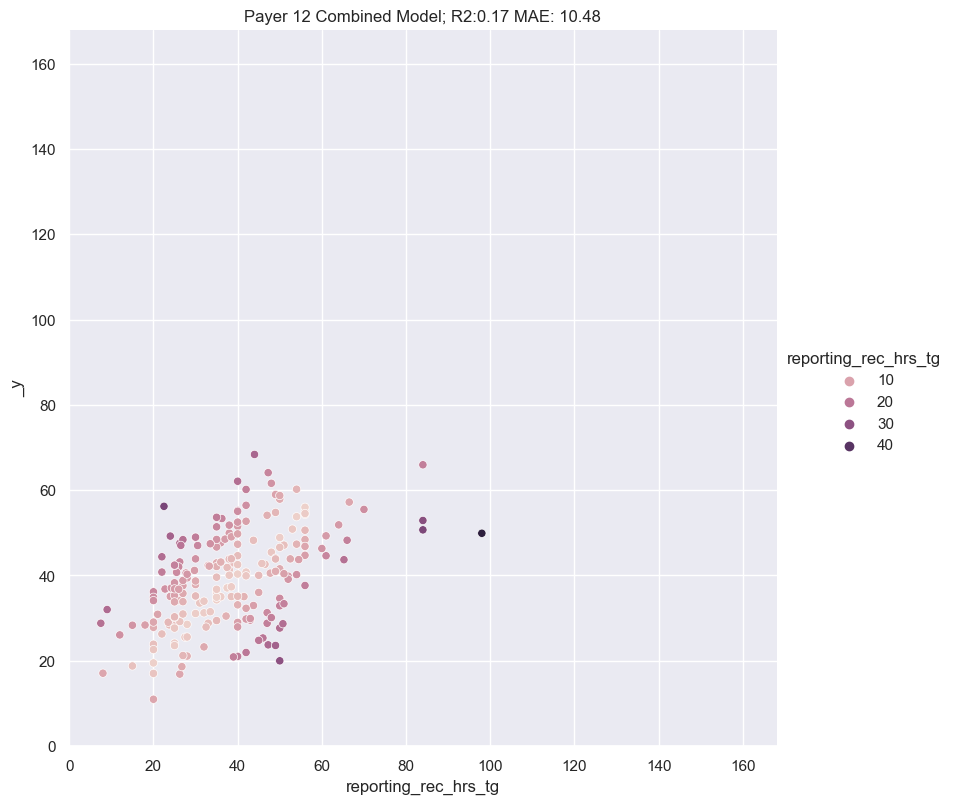

Payer 12 All assessor model features training
transfer_bed_to_chair_ft 0.158  +/- 0.010
age_ft   0.151  +/- 0.009
toileting_ft 0.079  +/- 0.005
heart_ddos_ft 0.063  +/- 0.004
meal_prep_ft 0.047  +/- 0.003
hyperlipidemia_ddos_ft 0.044  +/- 0.003
grooming_ft 0.043  +/- 0.003
neurocognitive_ddos_ft 0.037  +/- 0.003
hypertension_ddos_ft 0.037  +/- 0.002
bathing_ft 0.037  +/- 0.002
benign_prostatic_hyperplasia_ddos_ft 0.036  +/- 0.003
diabetes_ddos_ft 0.032  +/- 0.002
transfer_chair_to_standing_ft 0.030  +/- 0.002
shopping_ft 0.027  +/- 0.002
rheumatoid_arthritis_ddos_ft 0.025  +/- 0.002
incontinence_frequency_ft 0.023  +/- 0.002
medication_management_ft 0.022  +/- 0.001
dressing_ft 0.021  +/- 0.002
eating_ft 0.018  +/- 0.001
anemia_ddos_ft 0.018  +/- 0.001
alert_oriented_day_time_ft 0.018  +/- 0.001
peripheral_vascular_ddos_ft 0.017  +/- 0.001
behavioral_health_ddos_ft 0.015  +/- 0.001
mobility_ft 0.013  +/- 0.001
ckd_ddos_ft 0.012  +/- 0.001
pulmonary_ddos_ft 0.011  +/- 0.001
has_dementia

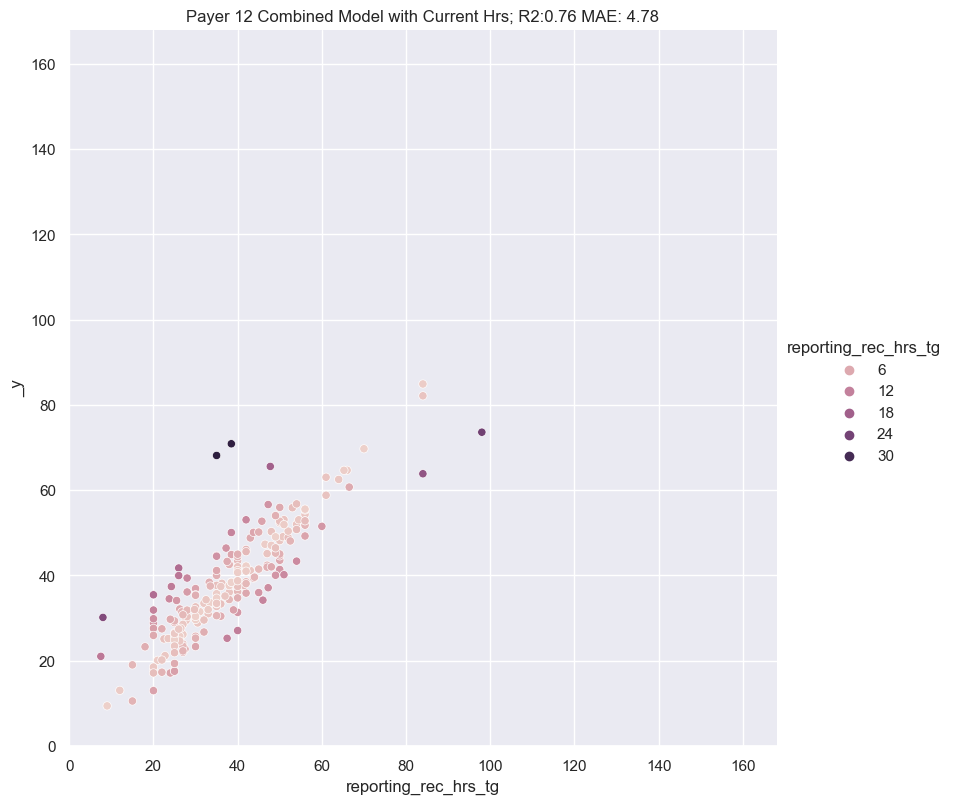

Payer 12 All assessor model features with current hrs
reporting_current_hrs_ft 1.292  +/- 0.059
neurocognitive_ddos_ft 0.030  +/- 0.005
age_ft   0.025  +/- 0.002
heart_ddos_ft 0.024  +/- 0.003
dressing_ft 0.019  +/- 0.002
bathing_ft 0.016  +/- 0.001
toileting_ft 0.014  +/- 0.001
transfer_chair_to_standing_ft 0.013  +/- 0.002
transfer_bed_to_chair_ft 0.011  +/- 0.001
diabetes_ddos_ft 0.009  +/- 0.001
hypertension_ddos_ft 0.008  +/- 0.001
grooming_ft 0.007  +/- 0.001
ckd_ddos_ft 0.007  +/- 0.001
hyperlipidemia_ddos_ft 0.006  +/- 0.000
shopping_ft 0.006  +/- 0.000
medication_management_ft 0.006  +/- 0.000
anemia_ddos_ft 0.005  +/- 0.000
pulmonary_ddos_ft 0.005  +/- 0.000
fluid_ddos_ft 0.004  +/- 0.000
mobility_ft 0.003  +/- 0.000
stroke_ddos_ft 0.003  +/- 0.000
rheumatoid_arthritis_ddos_ft 0.002  +/- 0.000
meal_prep_ft 0.002  +/- 0.000
has_dementia_ft 0.002  +/- 0.000
cataract_ddos_ft 0.002  +/- 0.000
benign_prostatic_hyperplasia_ddos_ft 0.002  +/- 0.000
alert_oriented_day_time_ft 0.002  

In [181]:
print('payers: ', payer_ids[1:])
out_dfs = []
for payer_id in payer_ids[1:-1]:
    print('Payer ID: ', payer_id)
    payer_df = df.loc[df.payer_id_ft == payer_id]
    print(f'n samples for {payer_id}', payer_df.shape[0])

    grps = payer_df.group_id_ft.unique().tolist()
    lookup = [i for i in range(len(grps))]
    payer_df = payer_df.assign(group_id_ft=payer_df.group_id_ft.apply(lambda x: grps.index(x)))

    # make sure data always exists
    missing_cat = payer_df[categorical_features].count() / payer_df.shape[0]

    # features present in < 50% samples
    low_freq_feats = [x for x in missing_cat.items() if x[1] <= .5]
    low_freq_feats 

    # make sure data always exists
    missing_cont = payer_df[cont_features].count() / payer_df.shape[0]
    missing_cont
    # len(features)

    # Likely want to drop low frequency features in categorical vars
    lf_feats = [lff[0] for lff in low_freq_feats]
    features = [f for f in features if f not in lf_feats]

    # len(features)
    # len(categorical_features)

    # need to drop the low_freq categorical feature indexes
    categorical_feature_indexes = categorical_feature_indexes[:-len(low_freq_feats)]

    # len(categorical_feature_indexes)

    ### Train Validation Test Split

    payer_df.submitted_last_30d.value_counts()

    # test set: all sferes submitted in last 30d plus any other sferes for thos patients
    test_df = payer_df.loc[payer_df.submitted_last_30d]
    test_df_patient_ids = test_df.patient_id.unique()
    test_df = payer_df.loc[payer_df.patient_id.isin(test_df_patient_ids)]
    print(f'{test_df.shape[0]} test samples, for {test_df_patient_ids.shape[0]} unique patients')

    training_df = payer_df.loc[~payer_df.patient_id.isin(test_df_patient_ids)]
    training_df_patient_ids = training_df.patient_id.unique()
    print(f'{training_df.shape[0]} training samples, for {training_df_patient_ids.shape[0]} unique patients')

    val_pct = 0.15
    val_df_patient_ids = random.sample(list(training_df_patient_ids), int(training_df.shape[0]*val_pct))
    val_df = training_df.loc[training_df.patient_id.isin(val_df_patient_ids)]
    val_df.shape[0]
    print(f'{val_df.shape[0]} val samples, for {len(val_df_patient_ids)} unique patients')

    train_no_val_df = training_df.loc[~training_df.patient_id.isin(val_df_patient_ids)]
    print(f'{train_no_val_df.shape[0]} train samples, for {train_no_val_df.patient_id.unique().shape[0]} unique patients')


    ### All assessor model

    x_train = train_no_val_df[features]
    y_train = train_no_val_df[target]
    x_val = val_df[features]
    y_val = val_df[target]
    
    x_train = training_df[features]
    y_train = training_df[target]
    x_val = test_df[features]
    y_val = test_df[target]

    aa_est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                           max_iter=1000).fit(x_train, y_train)

    aa_preds = aa_est.predict(x_val)

    # preds vs rec
    ax = sns.relplot(x=y_val, y=aa_preds, height=8, hue=np.abs(y_val - aa_preds))
    ax.set(ylim=(0, 168))
    ax.set(xlim=(0, 168))
    ax.set(title=f'Payer {payer_id} Combined Model; R2:{aa_est.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds)):.02f}');
    plt.show()

    print(f'Payer {payer_id} All assessor model features training')
    r = permutation_importance(aa_est, x_train, y_train,
                               n_jobs=-1,
                               n_repeats=50,
                               random_state=0)

    best_features = []
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            best_features.append(features[i])
            print(f"{features[i]:<8} "
                  f"{r.importances_mean[i]:.3f} "
                  f" +/- {r.importances_std[i]:.3f}")
    #
    
    # quantile model
    # Set lower and upper quantile
    LOWER_ALPHA = 0.05
    UPPER_ALPHA = 0.95

    lower_model = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                                loss="quantile",
                                                quantile=LOWER_ALPHA
                                               ).fit(x_train, y_train)

    upper_model = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                                loss="quantile",
                                                quantile=UPPER_ALPHA
                                               ).fit(x_train, y_train)

    l_preds = lower_model.predict(x_val)
    h_preds = upper_model.predict(x_val)

    features_ch = features + ['reporting_current_hrs_ft']

    x_train = training_df[features_ch]
    y_train = training_df[target]
    x_val = test_df[features_ch]
    y_val = test_df[target]

    aa_est_ch = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                           max_iter=1000).fit(x_train, y_train)

    aa_preds_ch = aa_est_ch.predict(x_val)

    # preds vs rec
    ax = sns.relplot(x=y_val, y=aa_preds_ch, height=8, hue=np.abs(y_val - aa_preds_ch))
    ax.set(ylim=(0, 168))
    ax.set(xlim=(0, 168))
    ax.set(title=f'Payer {payer_id} Combined Model with Current Hrs; R2:{aa_est_ch.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds_ch)):.02f}');
    plt.show()

    print(f'Payer {payer_id} All assessor model features with current hrs')
    r = permutation_importance(aa_est_ch, x_train, y_train,
                               n_jobs=-1,
                               n_repeats=50,
                               random_state=0)

    best_features = []
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            best_features.append(features_ch[i])
            print(f"{features_ch[i]:<8} "
                  f"{r.importances_mean[i]:.3f} "
                  f" +/- {r.importances_std[i]:.3f}")
    #
    
    # quantile model
    # Set lower and upper quantile
    LOWER_ALPHA = 0.05
    UPPER_ALPHA = 0.95

    lower_model = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                                loss="quantile",
                                                quantile=LOWER_ALPHA
                                               ).fit(x_train, y_train)

    upper_model = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                                loss="quantile",
                                                quantile=UPPER_ALPHA
                                               ).fit(x_train, y_train)

    l_preds_ch = lower_model.predict(x_val)
    h_preds_ch = upper_model.predict(x_val)

    out_df = test_df.assign(pred=aa_preds,
                            low_pred=l_preds,
                            high_pred=h_preds,
                            pred_w_current_hrs=aa_preds_ch,
                            low_pred_w_current_hrs=l_preds_ch,
                            high_pred_w_current_hrs=h_preds_ch
                           )
    
    out_dfs.append(out_df)
   

#### Results 

In [182]:
all_payers_df = pd.concat(out_dfs)

In [183]:
all_payers_df = all_payers_df.assign(
                             in_range=(all_payers_df.reporting_rec_hrs_tg >= all_payers_df.low_pred) & (all_payers_df.reporting_rec_hrs_tg <= all_payers_df.high_pred),
                             in_range_w_cur_hrs=(all_payers_df.reporting_rec_hrs_tg >= all_payers_df.low_pred_w_current_hrs) & (all_payers_df.reporting_rec_hrs_tg <= all_payers_df.high_pred_w_current_hrs)
)

all_payers_df.head()

,sfere_id,patient_id,payer_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,group_id_ft,glaucoma_ddos_ft,cataract_ddos_ft,behavioral_health_ddos_ft,osteoporosis_ddos_ft,hiv_ddos_ft,transplants_ddos_ft,obesity_ddos_ft,cancer_ddos_ft,hip_pelvic_fracture_ddos_ft,sclerosis_ddos_ft,rheumatoid_arthritis_ddos_ft,ckd_ddos_ft,hyperlipidemia_ddos_ft,diabetes_ddos_ft,hypothyroidism_ddos_ft,pressure_ulcer_ddos_ft,weight_loss_ddos_ft,heart_ddos_ft,peptic_ulcer_ddos_ft,anemia_ddos_ft,substance_abuse_ddos_ft,liver_ddos_ft,disabled_ddos_ft,fall_ddos_ft,stroke_ddos_ft,paralysis_ddos_ft,hypertension_ddos_ft,peripheral_vascular_ddos_ft,coagulation_ddos_ft,fluid_ddos_ft,benign_prostatic_hyperplasia_ddos_ft,tbi_ddos_ft,neurocognitive_ddos_ft,pulmonary_ddos_ft,glaucoma_tc_ft,cataract_tc_ft,behavioral_health_tc_ft,osteoporosis_tc_ft,hiv_tc_ft,transplants_tc_ft,obesity_tc_ft,cancer_tc_ft,hip_pelvic_fracture_tc_ft,sclerosis_tc_ft,rheumatoid_arthritis_tc_ft,ckd_tc_ft,hyperlipidemia_tc_ft,diabetes_tc_ft,hypothyroidism_tc_ft,pressure_ulcer_tc_ft,weight_loss_tc_ft,heart_tc_ft,peptic_ulcer_tc_ft,anemia_tc_ft,substance_abuse_tc_ft,liver_tc_ft,disabled_tc_ft,fall_tc_ft,stroke_tc_ft,paralysis_tc_ft,hypertension_tc_ft,peripheral_vascular_tc_ft,coagulation_tc_ft,fluid_tc_ft,benign_prostatic_hyperplasia_tc_ft,tbi_tc_ft,neurocognitive_tc_ft,pulmonary_tc_ft,submitted_last_30d,pred,low_pred,high_pred,pred_w_current_hrs,low_pred_w_current_hrs,high_pred_w_current_hrs,in_range,in_range_w_cur_hrs
139,40294,1680,2,72,2,2,0,2,2,1,2.0,2,NaN,1,1.0,0.0,0,0,1,0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,20.0,20.0,0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,72.28,922.61,0.0,0.0,0.0,0.00,1140.79,0.0,0.0,522.96,0.00,922.61,0.00,0.00,0.0,0.0,0.00,0.0,737.86,0.0,0.00,0.0,0.00,0.00,1093.63,2093.39,0.00,0.0,0.0,0.0,0.0,0.0,0.00,True,25.888322,11.889391,48.782408,16.979869,13.824021,21.604218,True,True
152,9476,127,2,64,0,0,1,0,2,0,2.0,2,NaN,1,2.0,0.0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,61.0,26.0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,5.0,14.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,10786.68,0.0,0.0,0.0,553.87,0.00,0.0,0.0,13042.63,0.00,570.40,1553.68,0.00,0.0,0.0,0.00,0.0,127.34,0.0,0.00,0.0,97.85,0.00,0.00,11275.82,0.00,0.0,0.0,0.0,0.0,0.0,0.00,False,15.255929,9.653442,32.578841,42.379232,27.589818,61.163017,True,False
153,38369,127,2,64,2,2,1,2,3,1,2.0,2,NaN,1,2.0,2.0,0,0,1,2,1.0,0.0,2.0,1.0,0.0,0.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,60.0,60.0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,4.0,13.0,0.0,0.0,0.0,2.0,0.0,10.0,0.0,1.0,0.0,0.0,3.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,488.20,0.00,0.0,0.0,467.93,0.00,456.26,1917.45,0.00,0.0,0.0,138.06,0.0,2686.82,0.0,78.84,0.0,0.00,136.64,38004.69,37936.67,0.00,0.0,0.0,0.0,0.0,0.0,0.00,True,33.278278,19.705565,47.483220,54.153361,40.765787,59.583950,False,False
156,5593,1641,2,73,0,1,0,3,3,1,3.0,2,NaN,1,0.0,2.0,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,39.0,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0

In [184]:
# all_payers_df.to_csv('../data/ds_by_payer_model_results_20230112.csv', index=False)

In [185]:
output_df = pd.read_csv('../data/ds_all_payer_model_results_20230110.csv')

In [186]:
output_df.head()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,in_range,in_range_w_cur_hrs,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,neurocognitive_ddos_ft
0,35771,12551,8,19.43,19.43,22.37,2.94,8.23,33.58,16.07,19.47,0.84,True,True,55,1,1,3,3,3,3,3,2,2.0,2.0,0.0,1.0,0.0,NaN
1,37496,14407,8,9.20,10.69,10.49,1.29,3.48,20.36,6.49,11.01,0.37,True,True,56,0,0,3,3,0,3,0,1,2.0,1.0,0.0,1.0,0.0,0.0
2,36001,12569,8,5.17,7.13,10.63,5.46,2.63,20.03,4.96,7.22,1.57,True,True,62,0,0,2,3,0,0,2,1,2.0,0.0,0.0,1.0,0.0,0.0
3,39093,16312,8,5.17,NaN,6.20,1.03,2.25,10.34,4.65,47.40,0.30,True,True,78,0,0,0,2,0,0,0,0,2.0,1.0,0.0,1.0,0.0,0.0
4,37888,18539,8,7.99,9.77,11.31,3.32,3.62,21.64,6.41,10.19,0.95,True,True,70,0,0,2,2,1,2,0,1,1.0,1.0,1.0,1.0,1.0,0.0


In [187]:
all_payers_df.rename({c: f'payer_model_{c}' for c in all_payers_df.columns[-8:]}, axis=1, inplace=True)
# all_payers_df.head()

In [188]:
merged = output_df.merge(all_payers_df[['sfere_id'] + all_payers_df.columns[-8:].tolist()], on='sfere_id', how='left')
merged.head()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,in_range,in_range_w_cur_hrs,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,neurocognitive_ddos_ft,payer_model_pred,payer_model_low_pred,payer_model_high_pred,payer_model_pred_w_current_hrs,payer_model_low_pred_w_current_hrs,payer_model_high_pred_w_current_hrs,payer_model_in_range,payer_model_in_range_w_cur_hrs
0,35771,12551,8,19.43,19.43,22.37,2.94,8.23,33.58,16.07,19.47,0.84,True,True,55,1,1,3,3,3,3,3,2,2.0,2.0,0.0,1.0,0.0,NaN,12.048142,8.391085,26.579580,15.264060,12.449821,21.902931,True,True
1,37496,14407,8,9.20,10.69,10.49,1.29,3.48,20.36,6.49,11.01,0.37,True,True,56,0,0,3,3,0,3,0,1,2.0,1.0,0.0,1.0,0.0,0.0,7.938600,3.816074,22.268505,8.552891,6.399905,10.413610,True,True
2,36001,12569,8,5.17,7.13,10.63,5.46,2.63,20.03,4.96,7.22,1.57,True,True,62,0,0,2,3,0,0,2,1,2.0,0.0,0.0,1.0,0.0,0.0,13.381573,4.138499,11.940851,5.730661,4.534128,7.257484,True,True
3,39093,16312,8,5.17,NaN,6.20,1.03,2.25,10.34,4.65,47.40,0.30,True,True,78,0,0,0,2,0,0,0,0,2.0,1.0,0.0,1.0,0.0,0.0,6.717758,2.045161,8.957599,2.794995,2.109193,28.762672,True,True
4,37888,18539,8,7.99,9.77,11.31,3.32,3.62,21.64,6.41,10.19,0.95,True,True,70,0,0,2,2,1,2,0,1,1.0,1.0,1.0,1.0,1.0,0.0,12.785037,5.923261,19.363103,10.563747,6.147329,9.718624,True,True


In [189]:
cols = [
    'sfere_id',
    'patient_id',
    'payer_id_ft',
    'reporting_rec_hrs_tg',
    'reporting_current_hrs_ft',
    'predicted_hrs',
    'payer_model_pred',
    'payer_model_pred_w_current_hrs',
    'lower_bound_preds',
    'upper_bound_preds',
    'payer_model_low_pred',
    'payer_model_high_pred',
    'lower_bound_preds_w_cur_hrs',
    'upper_bound_preds_w_cur_hrs',
    'payer_model_low_pred_w_current_hrs',
    'payer_model_high_pred_w_current_hrs',
    'error',
    'payer_error_std',
    'in_range',
    'in_range_w_cur_hrs',
    'payer_model_in_range',
    'payer_model_in_range_w_cur_hrs',
    'age_ft',
    'transfer_bed_to_chair_ft',
    'transfer_chair_to_standing_ft',
    'dressing_ft',
    'bathing_ft',
    'eating_ft',
    'grooming_ft',
    'toileting_ft',
    'meal_prep_ft',
    'housework_ft',
    'transportation_ft',
    'comprehension_ft',
    'alert_oriented_day_time_ft',
    'has_dementia_ft',
    'neurocognitive_ddos_ft',
]


In [190]:
merged[cols]

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,payer_model_pred,payer_model_pred_w_current_hrs,lower_bound_preds,upper_bound_preds,payer_model_low_pred,payer_model_high_pred,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_model_low_pred_w_current_hrs,payer_model_high_pred_w_current_hrs,error,payer_error_std,in_range,in_range_w_cur_hrs,payer_model_in_range,payer_model_in_range_w_cur_hrs,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,neurocognitive_ddos_ft
0,35771,12551,8,19.43,19.43,22.37,12.048142,15.264060,8.23,33.58,8.391085,26.579580,16.07,19.47,12.449821,21.902931,2.94,0.84,True,True,True,True,55,1,1,3,3,3,3,3,2,2.0,2.0,0.0,1.0,0.0,NaN
1,37496,14407,8,9.20,10.69,10.49,7.938600,8.552891,3.48,20.36,3.816074,22.268505,6.49,11.01,6.399905,10.413610,1.29,0.37,True,True,True,True,56,0,0,3,3,0,3,0,1,2.0,1.0,0.0,1.0,0.0,0.0
2,36001,12569,8,5.17,7.13,10.63,13.381573,5.730661,2.63,20.03,4.138499,11.940851,4.96,7.22,4.534128,7.257484,5.46,1.57,True,True,True,True,62,0,0,2,3,0,0,2,1,2.0,0.0,0.0,1.0,0.0,0.0
3,39093,16312,8,5.17,NaN,6.20,6.717758,2.794995,2.25,10.34,2.045161,8.957599,4.65,47.40,2.109193,28.762672,1.03,0.30,True,True,True,True,78,0,0,0,2,0,0,0,0,2.0,1.0,0.0,1.0,0.0,0.0
4,37888,18539,8,7.99,9.77,11.31,12.785037,10.563747,3.62,21.64,5.923261,19.363103,6.41,10.19,6.147329,9.718624,3.32,0.95,True,True,True,True,70,0,0,2,2,1,2,0,1,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,38596,50257,6,20.25,23.00,37.34,39.358365,23.295147,19.91,57.02,22.304816,49.801275,19.80,23.03,19.723134,28.523052,17.09,2.28,True,True,False,True,41,3,3,2,3,2,1,2,1,NaN,2.0,0.0,1.0,0.0,0.0
1934,38900,31602,6,19.00,NaN,21.20,22.010399,24.979153,13.85,31.79,15.895677,27.140303,15.79,49.64,14.329076,33.123076,2.20,0.29,True,True,True,True,77,0,0,1,1,0,0,0,2,NaN,1.0,0.0,1.0,0.0,2.0
1935,38910,49803,6,34.00,38.00,25.66,25.464623,29.573822,14.22,39.36,16.409139,31.140463,21.83,38.10,27.657003,34.783912,8.34,1.11,True,True,False,True,62,2,2,2,2,2,0,0,1,NaN,1.0,0.0,1.0,0.0,0.0
1936,40238,49720,6,54.25,54.25,36.09,44.717463,48.280631,16.19,48.21,20.084234,53.677737,41.33,56.23,40.684436,51.160382,18.16,2.42,False,True,False,False,51,2,2,3,3,0,3,2,1,NaN,0.0,0.0,1.0,0.0,0.0


In [194]:
# merged[cols].to_csv('../data/combined_model_results_20230112.csv', index=False)

In [192]:
df = merged[cols]

In [193]:
df.head()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,payer_model_pred,payer_model_pred_w_current_hrs,lower_bound_preds,upper_bound_preds,payer_model_low_pred,payer_model_high_pred,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_model_low_pred_w_current_hrs,payer_model_high_pred_w_current_hrs,error,payer_error_std,in_range,in_range_w_cur_hrs,payer_model_in_range,payer_model_in_range_w_cur_hrs,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_day_time_ft,has_dementia_ft,neurocognitive_ddos_ft
0,35771,12551,8,19.43,19.43,22.37,12.048142,15.264060,8.23,33.58,8.391085,26.579580,16.07,19.47,12.449821,21.902931,2.94,0.84,True,True,True,True,55,1,1,3,3,3,3,3,2,2.0,2.0,0.0,1.0,0.0,NaN
1,37496,14407,8,9.20,10.69,10.49,7.938600,8.552891,3.48,20.36,3.816074,22.268505,6.49,11.01,6.399905,10.413610,1.29,0.37,True,True,True,True,56,0,0,3,3,0,3,0,1,2.0,1.0,0.0,1.0,0.0,0.0
2,36001,12569,8,5.17,7.13,10.63,13.381573,5.730661,2.63,20.03,4.138499,11.940851,4.96,7.22,4.534128,7.257484,5.46,1.57,True,True,True,True,62,0,0,2,3,0,0,2,1,2.0,0.0,0.0,1.0,0.0,0.0
3,39093,16312,8,5.17,NaN,6.20,6.717758,2.794995,2.25,10.34,2.045161,8.957599,4.65,47.40,2.109193,28.762672,1.03,0.30,True,True,True,True,78,0,0,0,2,0,0,0,0,2.0,1.0,0.0,1.0,0.0,0.0
4,37888,18539,8,7.99,9.77,11.31,12.785037,10.563747,3.62,21.64,5.923261,19.363103,6.41,10.19,6.147329,9.718624,3.32,0.95,True,True,True,True,70,0,0,2,2,1,2,0,1,1.0,1.0,1.0,1.0,1.0,0.0
